# Testing

## Dataset reader
Read images and their names from the "random_imgs_limited" folder containing 4 folders 0,1,2,3 and read five-dimensional labels for each image from the "image_binary_components.csv" file that contains the image name in the first column and class name in the second column and the five binary components of the image label. 

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import glob
import numpy as np

class ImageDataset(Dataset):
    def __init__(self, data_dir, img_size=256):
        self.data_dir = data_dir
        self.img_size = img_size
        
        # read the csv file
        self.df = pd.read_csv(os.path.join(data_dir, 'image_binary_components.csv'))

        # Get list of subdirectories in random_imgs_limited
        subdirs = [f.path for f in os.scandir(os.path.join(data_dir, 'random_imgs_limited')) if f.is_dir()]

        # Read image filenames from subdirectories
        filenames = []
        for subdir in subdirs:
            filenames.extend(glob.glob(os.path.join(subdir, '*.jpg')))
        self.df['filename'] = ''
        for index, row in self.df.iterrows():
            try:
                filename = next(x for x in filenames if row['Image name'] in x)
                self.df.at[index, 'filename'] = filename
            except StopIteration:
                pass

        # define image transforms
        self.transforms = transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_file = self.df.loc[idx, 'filename']
        img_label = torch.FloatTensor(self.df.loc[idx, ['Page width text line', 'Half page width text line', 'Page height vertical separator', 'Half page height vertical separator', 'Multi fonts']])
        
        # read the image file and make sure the image is in RGB format
        img = Image.open(img_file).convert('RGB')
        
        # apply image transforms
        img = self.transforms(img)
        
        return img, img_label

## Split dataset and customize network architecture
The dataset is split into training, validation, and testing subsets using a given percentage for each split. The last layer of the VGG-16 model is modified to output a 5-dimensional tensor.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import vgg16

# Define device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define batch size and number of epochs
batch_size = 16
num_epochs = 10

# Initialize ImageDataset for the entire dataset
dataset = ImageDataset('drive/My Drive/Colab Notebooks/page_classification/data/')

# Define the percentages for each split
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

# Get the number of samples in the dataset
dataset_size = len(dataset)

# Get the indices for the entire dataset
indices = list(range(dataset_size))

# Add a random seed for reproducibility
random_seed = 11
np.random.seed(random_seed)

# Shuffle the indices 
np.random.shuffle(indices)

# Calculate the number of samples in each split
n_train = int(np.floor(train_percentage * dataset_size))
n_val = int(np.floor(val_percentage * dataset_size))
n_test = int(np.floor(test_percentage * dataset_size))

# Split the dataset into training, validation, and testing subsets
train_subset = Subset(dataset, indices[:n_train])
val_subset = Subset(dataset, indices[n_train:n_train+n_val])
test_subset = Subset(dataset, indices[n_train+n_val:])

# Initialize DataLoader for training, validation, and testing subsets
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True)

vgg = vgg16(pretrained=True)

# Get number of input features to the last layer
num_features = vgg.classifier[-1].in_features 

# Define new last layer that outputs 5-dimensional tensor
last_layer = nn.Linear(num_features, 5)
# last_layer = nn.Sequential(
#     nn.Dropout(0.3),
#     nn.Linear(num_features, 5)
# )

# Modify the last layer
vgg.classifier[-1] = last_layer

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.9MB/s]


## Visualize random samples and their labels
Display a sample of images and their corresponding labels from the test dataset.

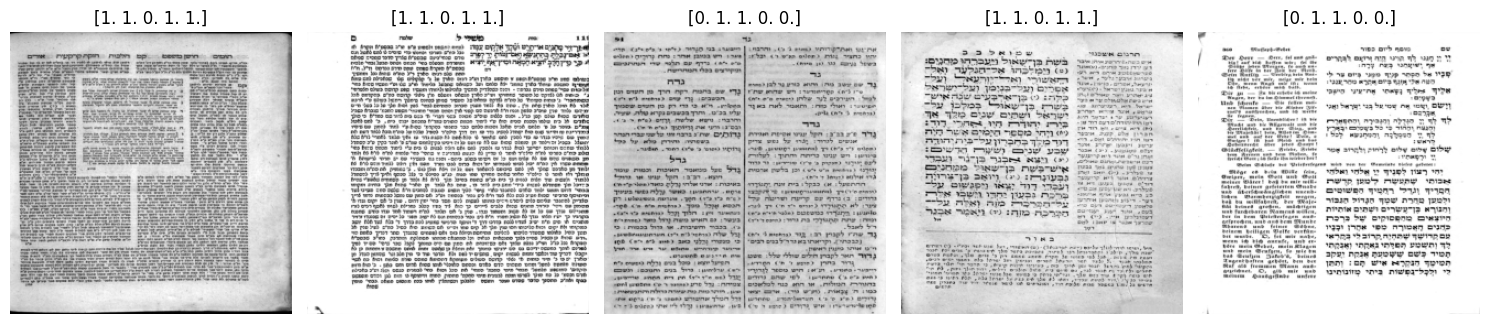

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of sample images from the train loader
sample_images, sample_labels = next(iter(test_loader))

# Convert images to numpy array for display
sample_images = sample_images.numpy()

# Extract the first 5 images and labels from the batch
sample_images = sample_images[:5]
sample_labels = sample_labels[:5]

# Convert the labels tensor to a numpy array for display
sample_labels = sample_labels.numpy()

# Create a figure with subplots for each sample image
fig, axs = plt.subplots(nrows=1, ncols=len(sample_images), figsize=(15, 5))

# Display each image and label using the corresponding subplot
for i in range(len(sample_images)):
    # Convert the image to grayscale
    grayscale_image = np.squeeze(sample_images[i]).mean(axis=0)
    axs[i].imshow(grayscale_image, cmap='gray')
    axs[i].set_axis_off()
    title = str(sample_labels[i])
    axs[i].set_title(title)

# Show the plot
plt.tight_layout()
plt.show()

### Load the best model to use it in testing

In [ ]:
vgg.load_state_dict(torch.load('drive/My Drive/Colab Notebooks/page_classification/model_test_97.pth'))

<All keys matched successfully>

### Visualize some test samples, their true labels and predicted labels
Generate 15 random indices from the test set to make predictions for. For each index, it gets the corresponding image and label from the test set and converts the image to a tensor, moves it to the device, and performs a forward pass through the model to get predicted labels. The output is then thresholded using the function threshold to convert predicted labels to 0 or 1. The function threshold applies a threshold of 0.5 to the predicted labels. The ground truth and predicted labels are then printed, and the image with its predicted and ground truth label as the title is displayed

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
vgg.to(device)
vgg.eval()

# Generate 15 random indices for test set
random_idx = random.sample(range(len(test_subset)), 15)

# Threshold function for converting predicted labels to 0 or 1
threshold = lambda x: 0 if x < 0.5 else 1

# Loop through each index and predict the label for that image
for idx in random_idx:
    # Get image and label from test set
    image, label = test_subset[idx]
    
    # Convert image to tensor and move to device
    image = torch.tensor(image).unsqueeze(0).to(device)
    
    # Forward pass through model to get predicted label
    output = vgg(image)
    pred = output.squeeze().tolist()
    
    # Apply thresholding to predicted label
    pred_thresholded = [threshold(x) for x in pred]
    
    # Check if prediction is incorrect
    if pred_thresholded != label:
        # Print ground truth and predicted label
        print(f"Ground Truth: {label}, Predicted Label: {pred_thresholded}")
        
        # Plot image with predicted and ground truth label as title
        plt.imshow(image[0].cpu().permute(1,2,0))
        plt.title(f"GT: {label}, Pred: {np.array(pred_thresholded)}")
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

### Calculate accuracy
Loop through each image in the test set, convert the image to a PyTorch tensor and move it to the device (e.g., GPU), and then perform a forward pass through the VGG model to obtain the predicted label. The predicted label is then thresholded to obtain a binary classification (0 or 1) using a threshold of 0.5. The predicted label is appended to a list of predicted labels, and the true label is appended to a list of true labels.


In [ ]:

# Generate predicted labels and true labels for test set
test_labels_pred = []
test_labels_true = []
for image, label in test_subset:
    # Convert image to tensor and move to device
    image = torch.tensor(image).unsqueeze(0).to(device)
    
    # Forward pass through model to get predicted label
    output = vgg(image)
    pred = output.squeeze().tolist()
    
    # Apply thresholding to predicted label
    pred_thresholded = [threshold(x) for x in pred]
    test_labels_pred.append(pred_thresholded)
    
    # Save true label
    test_labels_true.append(label.tolist()) # convert tensor to array

# Convert to numpy array
test_labels_pred = np.array(test_labels_pred)
test_labels_true = np.array(test_labels_true)


The accuracy function works by first counting the number of correct predictions (correct_count) by iterating through each row of y_true and y_pred and checking if they are equal using the np.array_equal function. Then it calculates the accuracy by dividing correct_count by the total number of samples (n_samples).

In [ ]:
def accuracy(y_true, y_pred):
    n_samples = len(y_true)
    correct_count = 0
    for i in range(n_samples):
        if np.array_equal(y_true[i], y_pred[i]):
            correct_count += 1
    acc = correct_count / n_samples
    return acc

In [ ]:
acc = accuracy(test_labels_true, test_labels_pred)
print("Accuracy:", acc)

Accuracy: 0.9705882352941176


## Confusion matrix
The code below takes the true and predicted labels for each test sample, and converts them into class labels for classification evaluation. It first defines a dictionary labels where each key corresponds to a class label (0, 1, 2, or 3), and each value is a binary vector that indicates the presence/absence of some predefined attributes. It then loops through the true labels, and assigns each sample to its corresponding class label based on the binary vector. Similarly, it loops through the predicted labels and assigns each sample to its corresponding class label if the predicted vector exactly matches one of the binary vectors in labels, or to the class whose binary vector is closest in Euclidean distance otherwise. The resulting true_class and pred_class lists can be used to compute the confusion matrix.

In [ ]:
# Define labels for each class
labels = {
    0: [0, 0, 0, 0, 0],
    1: [1, 0, 0, 0, 0],
    2: [0, 1, 1, 0, 0],
    3: [1, 1, 0, 1, 1]
}

true_class = []
for label in test_labels_true:
    if np.array_equal(label, labels[0]):
        true_class.append(0)
    elif np.array_equal(label, labels[1]):
        true_class.append(1)
    elif np.array_equal(label, labels[2]):
        true_class.append(2)
    elif np.array_equal(label, labels[3]):
        true_class.append(3)

pred_class = []
for label in test_labels_pred:
    found = False
    for i in range(len(labels)):
        if np.array_equal(label, labels[i]):
            pred_class.append(i)
            found = True
            break
    if not found:
        # find the nearest class based on Euclidean distance
        dist = [np.sum((label - labels[i]) ** 2) for i in range(len(labels))]
        nearest_class = dist.index(min(dist))
        pred_class.append(nearest_class)



In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_class, pred_class, labels=[0, 1, 2, 3])
print(cm)

[[29  1  0  0]
 [ 0 41  0  0]
 [ 0  0 25  0]
 [ 0  0  2 38]]
